# Possible numerical sources for bifurcation break

***

In our previous notebooks we observed an always-stable structural behavior for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_Reinforced_Box_Beam.ipynb). In both cases, the structures showed a buckled-like deformation shape for loads larger than the linear buckling load predicted by SOL 105. This behavior suggests that a bifurcation is present in the equilibrium manifold of our structures, and that we observe a broken bifurcation because at least one of the symmetry of the problem is broken. Since there can be both physical and numerical sources for this symmetry break, we need to rule out the latter kind to be confident that we are observing a physical behavior.

In this notebook we are going to investigate two possible numerical causes of the bifurcation break: the inconsistency of the orientation of the elements' normal vectors and the presence of physical ribs instead of multipoint constraints.

* [Consistency of normal vectors' orientation](#consistency)
    * [Unreinforced box beam](#unreinforced)
    * [Reinforced box beam](#reinforced)
* [Multipoint constraints in place of physical ribs](#multipoint-constraints)

## Consistency of normal vectors' orientation <a name="consistency"></a>

***

One possible numerical cause of the bifurcation break is the inconsistency of the elements' normal vectors' orientation. To preserve the symmetry of the problem, the normals of all elements of the box have to point either inward or outward. If there is a mixture of the two orientations, the symmetry of the problem is broken numerically. For the reinforced box beam, also the normals of all the elements of the ribs have to point in the same direction, that is to say either towards the root or towards the tip of the box beam.

We investigate both the unreinforced and reinforced box beam cases.

### Unreinforced box beam <a name="unreinforced"></a>

Similarly to our previous notebooks, we define the geometry of our box beam to obtain a scaled imitation of the CRM.

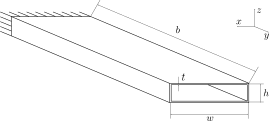

In [40]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [41]:
AR = 9   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.28  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/100  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.28 m
- wall thickness: 2.80 mm


Let's discretize our geometry and create the bdf input. We are going to prescribe a large edge length for the shell elements, as we only need to check the orientation of the elements' normals and we don't have to run any analysis. For the same reason we use dummy values for the material properties.

In [42]:
from resources import box_beam_utils  # module with useful functions to work with box beam problems

# Discretize geometry
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=h)
# Create BDF object
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=1, poisson_ratio=1, density=1, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)

subcase=0 already exists...skipping


We define a function to find the coordinates of the nodes and of the centroid of each element and also its normal.

In [43]:
import numpy as np

def find_nodes_centroids_normals(bdf_input):
    nodes = np.empty((len(bdf_input.elements), 4, 3))
    centroids = np.empty((len(bdf_input.elements), 3))
    normals = np.empty((len(bdf_input.elements), 3))
    for count, (eid, elem) in enumerate(bdf_input.elements.items()):
        nodes[count] = elem.get_node_positions()
        _, centroid, normal = elem.AreaCentroidNormal()
        centroids[count] = centroid
        normals[count] = normal
    return nodes, centroids, normals

Let's call `find_nodes_centroids_normals` for our unreinforced box beam and let's find the indices of the elements associated with the different structural parts: top skin, bottom skin, front spar and rear spar.

In [44]:
nodes_coordinates, centroids_coordinates, normal_vectors = find_nodes_centroids_normals(unreinforced_box_beam_bdf)
top_skin_indices = np.where(np.abs(centroids_coordinates[:,2]-h/2)<h/100)[0]
bottom_skin_indices = np.where(np.abs(centroids_coordinates[:,2]+h/2)<h/100)[0]
front_spar_indices = np.where(np.abs(centroids_coordinates[:,0])<h/100)[0]
rear_spar_indices = np.where(np.abs(centroids_coordinates[:,0]-w)<h/100)[0]
box_beam_parts = {'Top skin': top_skin_indices,
                  'Bottom skin': bottom_skin_indices,
                  'Front spar': front_spar_indices,
                  'Rear spar': rear_spar_indices}

Now we define a function to plot the elements and their normal for each structural part. We then use the function to visualize the normal vectors of the elements of the unreinforced box beam.

Top skin


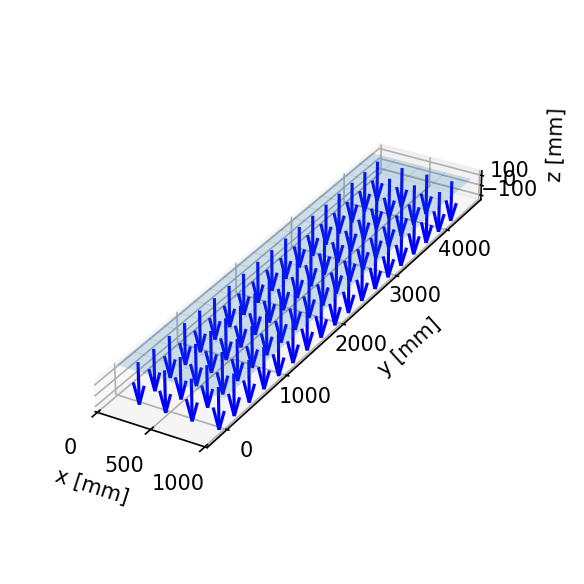

Bottom skin


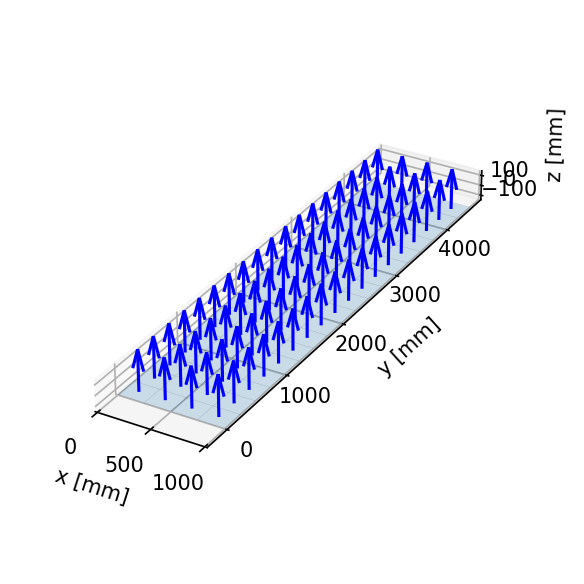

Front spar


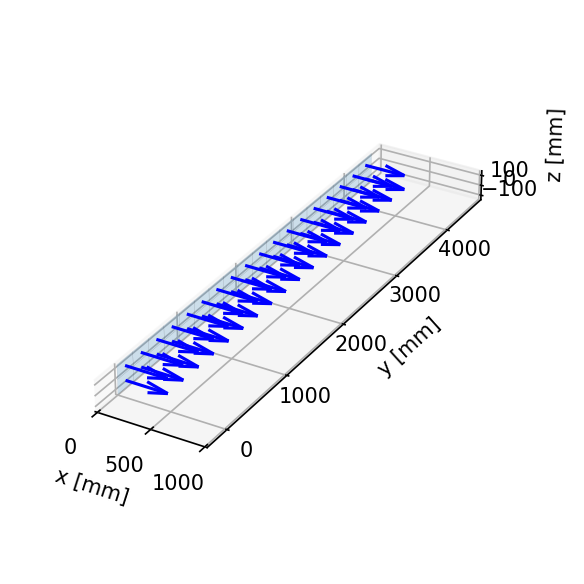

Rear spar


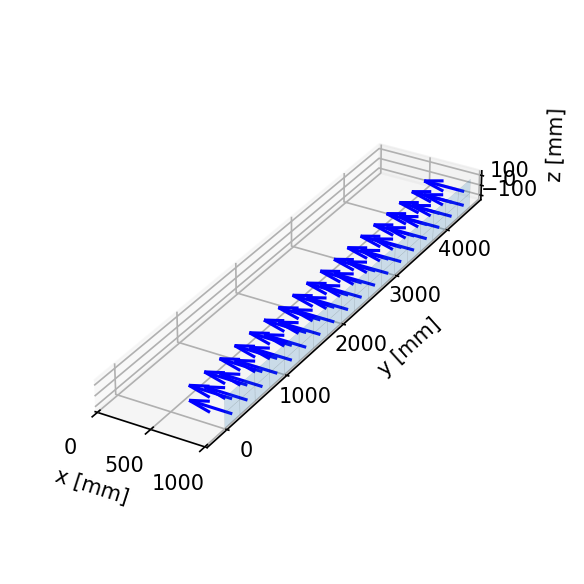

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_elements_normals(nodes, centroids, normals, parts):
    bounds = np.array([[np.amin(nodes[:, :, 0]), np.amax(nodes[:, :, 0])],
                       [np.amin(nodes[:, :, 1]), np.amax(nodes[:, :, 1])],
                       [np.amin(nodes[:, :, 2]), np.amax(nodes[:, :, 2])]])
    aspect_ratio = [x[1]-x[0] for x in list(bounds)]
    for part, indices in parts.items():
        print(part)
        # Create figure and axes
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # Plot elements
        pc = Poly3DCollection(nodes[indices, :, :], linewidths=.1, alpha=0.2)
        pc.set_edgecolor('k')
        ax.add_collection3d(pc)
        # Plot normal vectors
        ax.quiver(centroids[indices, 0], centroids[indices, 1], centroids[indices, 2], normals[indices, 0], normals[indices, 1], normals[indices,2], length=400, color='blue', arrow_length_ratio=.5)
        # Set axes label
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')
        ax.set_zlabel('z [mm]')
        # Set aspect ratio
        ax.set_box_aspect(aspect_ratio)
        # Set axes limits
        ax.set_xlim(bounds[0, :])
        ax.set_zlim(bounds[1, :])
        ax.set_zlim(bounds[2, :])
        # Adjust number of ticks of x and z axes
        ax.locator_params(axis='x', nbins=3)
        ax.locator_params(axis='z', nbins=2)
        # Adjust ticks label of y-axis
        ax.tick_params(axis='y', which='major', pad=15)
        # Adjust axis label y and z axes
        ax.yaxis.labelpad = 50
        ax.zaxis.labelpad = 10
        # Show plot
        plt.show()

plt.rcParams['figure.dpi'] = 150 # set default dpi of figures
plot_elements_normals(nodes_coordinates, centroids_coordinates, normal_vectors, box_beam_parts)

We observe that all normal vectors are oriented inwards and as a consequence we can state that they have a consistent orientation.

### Reinforced box beam <a name="reinforced"></a>

Let's take a look at the reinforced box beam. We use the same geometry of the unreinforced box beam and we prescribe a rib spacing equal to half the width of the box beam cross-section.

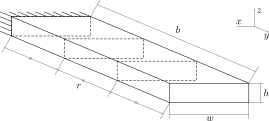

In [46]:
SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamGeometry.svg'))

In [47]:
# Prescribed spacing r
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
print(f'Number of ribs: {no_ribs:.0f}')
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)

Number of ribs: 10


Now we generate a mesh of our reinforced box beam and we create the corresponding bdf input.

In [48]:
# Discretize geometry
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations ,width=w, height=h, edge_length=h)
# Create BDF object
reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(young_modulus=1, poisson_ratio=1, density=1, shell_thickness=t, nodes_xyz_array=reinforced_box_beam_mesh.points, nodes_connectivity_matrix=reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:])

subcase=0 already exists...skipping


Once again we use the `find_nodes_centroids_normal` and the `plot_elements_normals` functions to find the normal vectors of every element of the structure and plot them.

Top skin


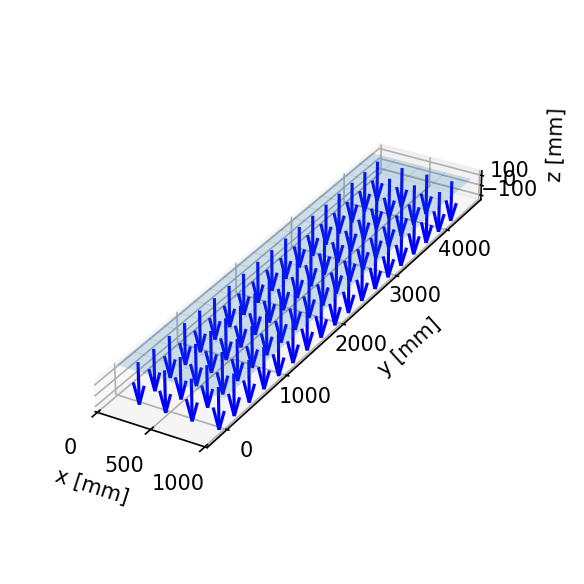

Bottom skin


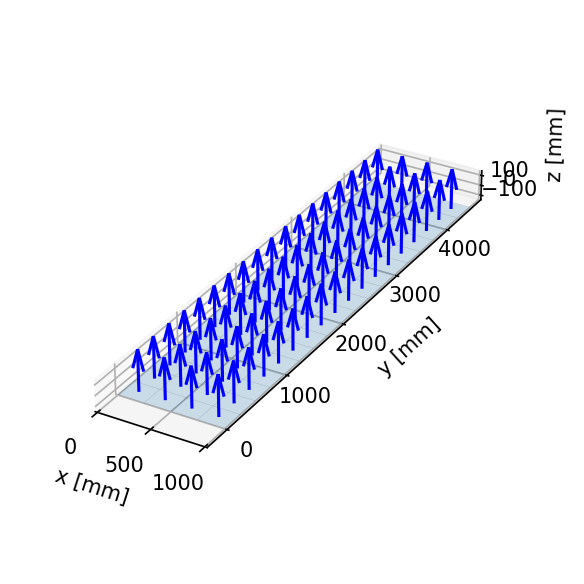

Front spar


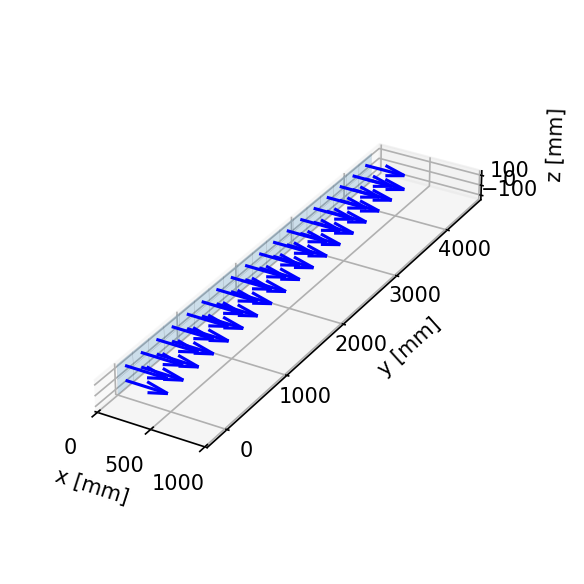

Rear spar


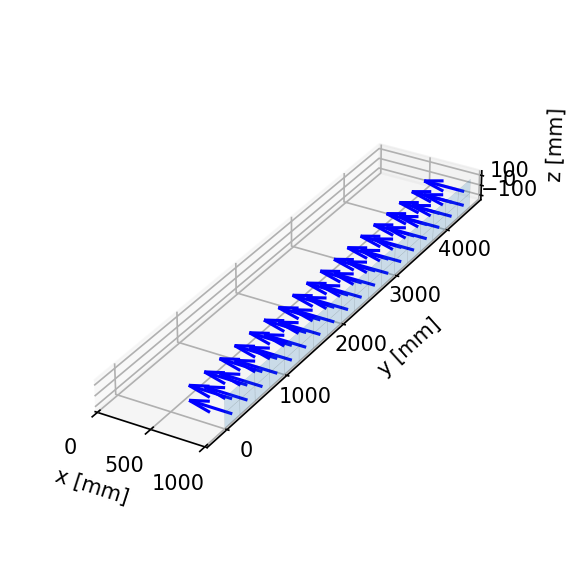

Ribs


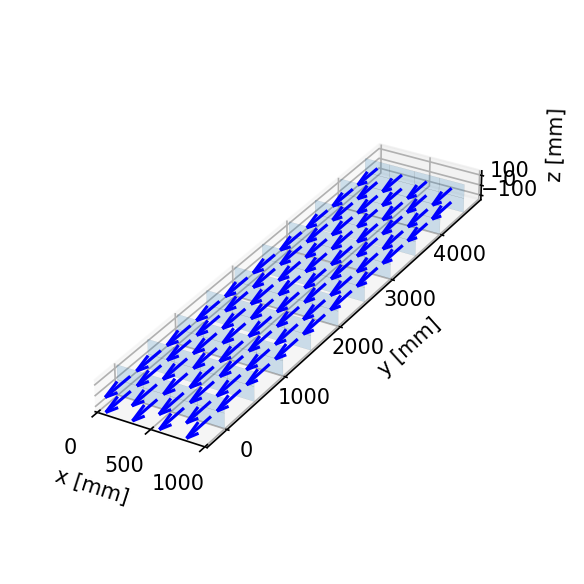

In [49]:
# Find normal vectors and coordinates of nodes and centroids
nodes_coordinates, centroids_coordinates, normal_vectors = find_nodes_centroids_normals(reinforced_box_beam_bdf)
# Find indices corresponding to the different structural parts
top_skin_indices = np.where(np.abs(centroids_coordinates[:,2]-h/2)<h/100)[0]
bottom_skin_indices = np.where(np.abs(centroids_coordinates[:,2]+h/2)<h/100)[0]
front_spar_indices = np.where(np.abs(centroids_coordinates[:,0])<h/100)[0]
rear_spar_indices = np.where(np.abs(centroids_coordinates[:,0]-w)<h/100)[0]
ribs_indices = np.where(np.abs(centroids_coordinates[:,1] - ribs_y_locations[:, np.newaxis])<h/100)[1]
box_beam_parts = {'Top skin': top_skin_indices,
                  'Bottom skin': bottom_skin_indices,
                  'Front spar': front_spar_indices,
                  'Rear spar': rear_spar_indices,
                  'Ribs': ribs_indices}
# Plot normal vectors
plot_elements_normals(nodes_coordinates, centroids_coordinates, normal_vectors, box_beam_parts)

Also in this case we observe that the orientation of the normal vectors is consistent: the ones of the top skin, bottom skin, front spar and rear spar all point inwards, while the vectors of the ribs all point towards to root.

We can conclude that the orientation of the elements' normal vectors is not a cause of the symmetry break.

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [50]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()